In [1]:
#default_exp adapters.prophet

# Adapters for Prophet

In [2]:
#export
from copy import deepcopy

import numpy as np
import statsmodels.api as sm
import pandas as pd
try: 
    from prophet import Prophet
except ModuleNotFoundError as e:
        msg = (
            '{e}. Tou use prophet adapters you have to insall '
            'prophet. Please run `pip install prophet`. '
            'Note that it is recommended to install prophet '
            'using conda environments due to dependencies.'
        )
        raise ModuleNotFoundError(msg) from e
from statsforecast.arima import AutoARIMA

Importing plotly failed. Interactive plots will not work.


## Arima

In [3]:
#export
class AutoARIMAProphet(Prophet):
    """Returns best ARIMA model using external variables created 
    by the Prophet interface.
    
    This class receives as parameters the same as prophet.Prophet
    and statsforecast.arima.AutoARIMA.
    
    If your pipeline uses Prophet you can simply replace Prophet
    with AutoARIMAProphet and you'll be using AutoARIMA instead
    of Prophet.
    """
    
    def __init__(self, 
                 growth='linear',
                 changepoints=None,
                 n_changepoints=25,
                 changepoint_range=0.8,
                 yearly_seasonality='auto',
                 weekly_seasonality='auto',
                 daily_seasonality='auto',
                 holidays=None,
                 seasonality_mode='additive',
                 seasonality_prior_scale=10.0,
                 holidays_prior_scale=10.0,
                 changepoint_prior_scale=0.05,
                 mcmc_samples=0,
                 interval_width=0.80,
                 uncertainty_samples=1000,
                 stan_backend=None,
                 d=None,
                 D=None,
                 max_p=5,
                 max_q=5,
                 max_P= 2,
                 max_Q= 2,
                 max_order= 5,
                 max_d=2,
                 max_D=1,
                 start_p=2,
                 start_q=2,
                 start_P=1,
                 start_Q=1,
                 stationary=False,
                 seasonal=True,
                 ic='aicc',
                 stepwise=True,
                 nmodels=94,
                 trace=False,
                 approximation=False,
                 method=None,
                 truncate=None,
                 test='kpss',
                 test_kwargs=None,
                 seasonal_test='seas',
                 seasonal_test_kwargs=None,
                 allowdrift=False,
                 allowmean=False,
                 blambda=None,
                 biasadj=False,
                 parallel=False,
                 num_cores=2,
                 period=1):
        Prophet.__init__(self,
                         growth,
                         changepoints,
                         n_changepoints,
                         changepoint_range,
                         yearly_seasonality,
                         weekly_seasonality,
                         daily_seasonality,
                         holidays,
                         seasonality_mode,
                         seasonality_prior_scale,
                         holidays_prior_scale,
                         changepoint_prior_scale,
                         mcmc_samples,
                         interval_width,
                         uncertainty_samples,
                         stan_backend)
        self.arima = AutoARIMA(d=d,
                               D=D,
                               max_p=max_p,
                               max_q=max_q,
                               max_P=max_P,
                               max_Q=max_Q,
                               max_order=max_order,
                               max_d=max_d,
                               max_D=max_D,
                               start_p=start_p,
                               start_q=start_q,
                               start_P=start_P,
                               start_Q=start_Q,
                               stationary=stationary,
                               seasonal=seasonal,
                               ic=ic,
                               stepwise=stepwise,
                               nmodels=nmodels,
                               trace=trace,
                               approximation=approximation,
                               method=method,
                               truncate=truncate,
                               test=test,
                               test_kwargs=test_kwargs,
                               seasonal_test=seasonal_test,
                               seasonal_test_kwargs=seasonal_test_kwargs,
                               allowdrift=allowdrift,
                               allowmean=allowmean,
                               blambda=blambda,
                               biasadj=biasadj,
                               parallel=parallel,
                               num_cores=num_cores,
                               period=period)
    
    def fit(self, df, disable_seasonal_features=False, **kwargs):
        """Fit the AutoARIMAProphet model.

        Parameters
        ----------
        df: pd.DataFrame containing the history. Must have columns ds (date
            type) and y, the time series.
        disable_seasonal_features: bool
            Wheter disable seasonal features generated by Prophet.
        kwargs: Additional arguments.
        
        Returns
        -------
        The AutoARIMAProphet object.
        """
        if self.history is not None:
            raise Exception('Prophet object can only be fit once. '
                            'Instantiate a new object.')
        if ('ds' not in df) or ('y' not in df):
            raise ValueError(
                'Dataframe must have columns "ds" and "y" with the dates and '
                'values respectively.'
            )
        history = df[df['y'].notnull()].copy()
        if history.shape[0] < 2:
            raise ValueError('Dataframe has less than 2 non-NaN rows.')
        self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()

        history = self.setup_dataframe(history, initialize_scales=True)
        self.history = history
        self.set_auto_seasonalities()
        seasonal_features, prior_scales, component_cols, modes = (
            self.make_all_seasonality_features(history))
        self.train_component_cols = component_cols
        self.component_modes = modes
        self.fit_kwargs = deepcopy(kwargs)
        if disable_seasonal_features:
            seas = tuple(self.seasonalities.keys())
            seasonal_features = seasonal_features.loc[:,~seasonal_features.columns.str.startswith(seas)]
        self.xreg_cols = seasonal_features.columns
        
        y = history['y'].values
        X = seasonal_features.values if not seasonal_features.empty else None
        self.arima = self.arima.fit(y=y, X=X)

        return self

    def predict(self, df=None):
        """Predict using the AutoARIMAProphet model.
        
        Parameters
        ----------
        df: pd.DataFrame with dates for predictions (column ds.
            If not provided, predictions are
            made on the history.
            
        Returns
        -------
        A pd.DataFrame with the forecast components.
        """
        if self.history is None:
            raise Exception('Model has not been fit.')

        if df is None:
            df = self.history.copy()
        else:
            if df.shape[0] == 0:
                raise ValueError('Dataframe has no rows.')
            df = self.setup_dataframe(df.copy())
            
        seasonal_features = self.make_all_seasonality_features(df)[0].loc[:, self.xreg_cols]
        
        ds_forecast = set(df['ds'])
        h = len(ds_forecast - set(self.history['ds']))
        if h > 0:
            X = seasonal_features.values[-h:] if not seasonal_features.empty else None
            df2 = self.arima.predict(h=h, 
                                     X=X,
                                     level=int(100*self.interval_width))
        else:
            df2 = pd.DataFrame()
        if len(ds_forecast) > h: 
            in_sample = self.arima.predict_in_sample(level=int(100*self.interval_width))
            df2 = pd.concat([in_sample, df2]).reset_index(drop=True)

        yhat = df2.pop('mean')
        df2.columns = ['yhat_lower', 'yhat_upper']
        df2.insert(0, 'yhat', yhat)
        df2.insert(0, 'ds', df['ds'])
            
        return df2

### Peyton Manning example

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

#### Without additional info

Usually, a Prophet pipeline without external regressors looks like this.

2022-03-22 05:43:18 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/miniconda3/envs/statsforecast/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7975.23    0.00333027       229.371           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7993.56   0.000129511       136.478     0.02731           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7997.17   0.000734911       157.438      0.8599      0.8599      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       7998.51   8.30685e-05       244.937   2.117e-07       0.001      442  LS failed, Hessian reset 
     399       8000.57   8.73339e-05       65.5818           1           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8002.44   0.000319089    

/home/ubuntu/miniconda3/envs/statsforecast/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/miniconda3/envs/statsforecast/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


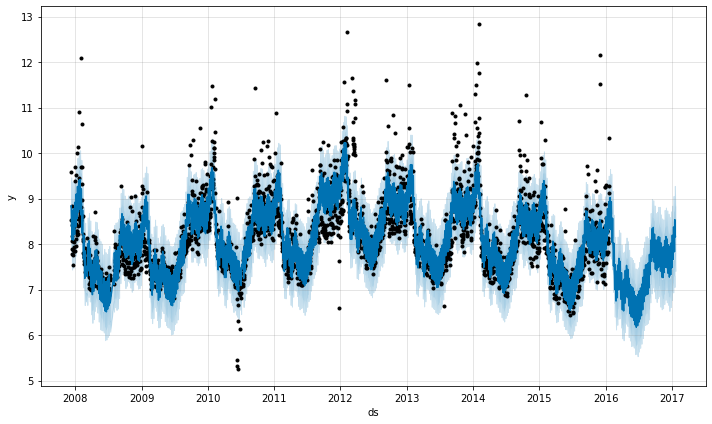

In [5]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(365)
forecast = m.predict(future)
fig = m.plot(forecast)

With the class `AutoARIMAProphet` you can simply replace `Prophet` and you'll be training an `auto_arima` model without changing the pipeline.

In [6]:
%%capture
m = AutoARIMAProphet()
m.fit(df)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

2022-03-22 05:43:23 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


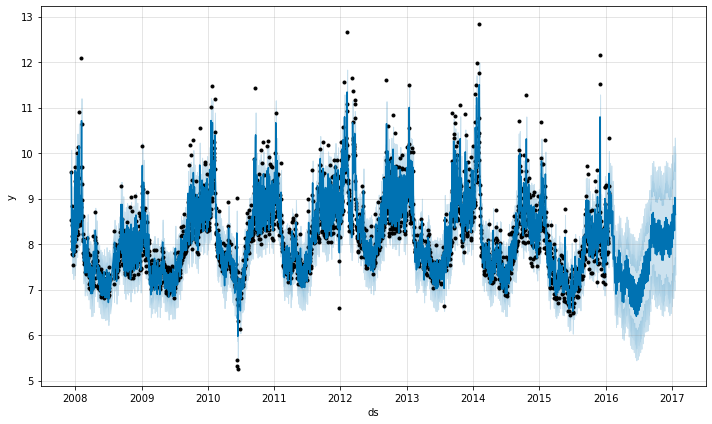

In [7]:
fig = m.plot(forecast)

### With exogenous regressors provided by prophet

Usually `Prophet` pipelines include the usage of external regressors such as holidays. 

In [8]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [9]:
%%capture
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

2022-03-22 05:43:55 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8151.96     0.0192759       1552.84           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8173.22    0.00218105       213.514           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       8176.74   2.63603e-05       93.9476   1.843e-07       0.001      337  LS failed, Hessian reset 
     299       8179.29   0.000753418       398.623      0.7759      0.7759      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8181.85    0.00284412         663.6      0.7573      0.7573      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8184.65    0.00164005    

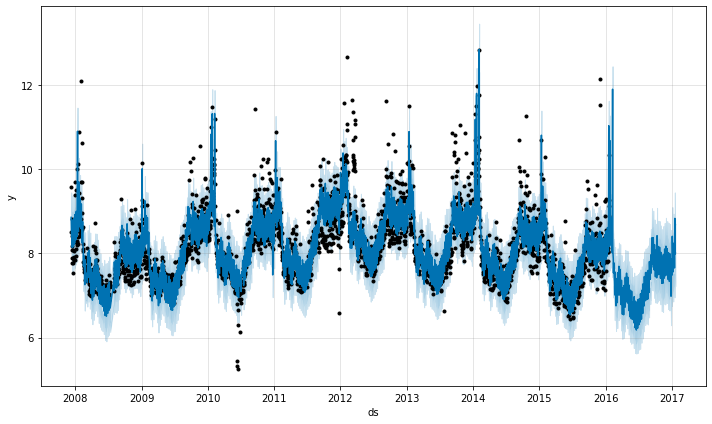

In [10]:
fig = m.plot(forecast)

The class `AutoARIMAProphet` allows you to handle these scenarios to fit an `auto_arima` model with exogenous variables. 

In [11]:
%%capture
m = AutoARIMAProphet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

2022-03-22 05:44:00 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


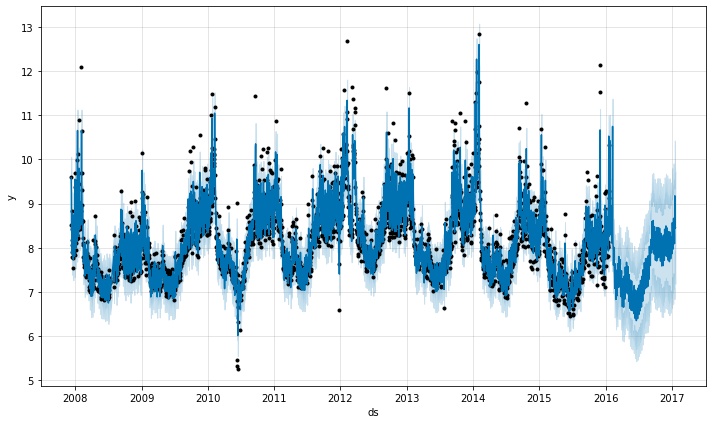

In [12]:
fig = m.plot(forecast)